In [1]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dataset_path = '/content/drive/MyDrive/Colab_Notebooks/Brain_Tumour'

In [3]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
# Determine the device to use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [5]:
model=nn.Sequential(
    nn.Conv2d(3,32,3,1,1),nn.ReLU(),nn.MaxPool2d(2),
    nn.Conv2d(32,64,3,1,1),nn.ReLU(),nn.MaxPool2d(2),
    nn.Conv2d(64,128,3,1,1),nn.ReLU(),nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(128*8*8,256),nn.ReLU(),nn.Dropout(0.5),
    nn.Linear(256,4),
).to(device)

In [10]:
opt=optim.AdamW(model.parameters(),1e-4)
loss_fn=nn.CrossEntropyLoss()


In [11]:
train_tf = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

test_tf = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_dl = DataLoader(
    datasets.ImageFolder('/content/drive/MyDrive/Colab_Notebooks/Brain_Tumour/Training', train_tf),
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_dl = DataLoader(
    datasets.ImageFolder('/content/drive/MyDrive/Colab_Notebooks/Brain_Tumour/Testing', test_tf),
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [13]:
model.train()
for epoch in range(25):
  running_loss = 0
  for x, y in train_dl:
    opt.zero_grad()
    x, y = x.to(device), y.to(device)
    pred = model(x)
    loss = loss_fn(pred, y)
    running_loss += loss
    loss.backward()
    opt.step()
  print(f'Epoch: {epoch+1}, Loss: {running_loss/len(train_dl)}')

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 1, Loss: 0.3280630111694336
Epoch: 2, Loss: 0.30390045046806335
Epoch: 3, Loss: 0.2954878807067871
Epoch: 4, Loss: 0.2695012092590332
Epoch: 5, Loss: 0.2510611116886139
Epoch: 6, Loss: 0.24203245341777802
Epoch: 7, Loss: 0.23104606568813324
Epoch: 8, Loss: 0.22158779203891754
Epoch: 9, Loss: 0.20942498743534088
Epoch: 10, Loss: 0.20054475963115692
Epoch: 11, Loss: 0.1812940239906311
Epoch: 12, Loss: 0.17295196652412415
Epoch: 13, Loss: 0.1650196760892868
Epoch: 14, Loss: 0.15515819191932678
Epoch: 15, Loss: 0.14806294441223145
Epoch: 16, Loss: 0.1396835446357727
Epoch: 17, Loss: 0.13553592562675476
Epoch: 18, Loss: 0.12668269872665405
Epoch: 19, Loss: 0.12150594592094421
Epoch: 20, Loss: 0.1152159571647644
Epoch: 21, Loss: 0.10947094112634659
Epoch: 22, Loss: 0.10572738945484161
Epoch: 23, Loss: 0.11149405688047409
Epoch: 24, Loss: 0.08890385925769806
Epoch: 25, Loss: 0.09511325508356094


In [14]:
model.eval()
test_loss, correct = 0.0, 0
with torch.no_grad():
  for x, y in test_dl:
    x, y = x.to(device), y.to(device)
    logits = model(x)
    test_loss += loss_fn(logits, y).item() * y.size(0)
    preds = logits.argmax(dim=1)
    correct += (preds == y).sum().item()
test_loss /= len(test_dl.dataset)
accuracy = 100.0 * correct / len(test_dl.dataset)
print(f'Test Loss: {test_loss}, Accuracy: {accuracy}')

Test Loss: 0.08582071004576433, Accuracy: 97.55911517925247


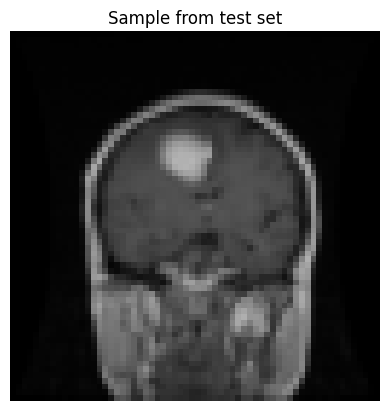

Predicted label: 1, Actual label: 1


In [15]:
import random
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
model.eval()
idx=random.randrange(len(test_dl.dataset))
img, label=test_dl.dataset[idx]
unnorm=img*0.5+0.5
plt.imshow(to_pil_image(unnorm))
plt.axis('off')
plt.title('Sample from test set')
plt.show()

with torch.no_grad():
  logits=model(img.unsqueeze(0).to(device))
  pred=logits.argmax(dim=1).item()
  print(f'Predicted label: {pred}, Actual label: {label}')